In [2]:
from ProjectTools import OpenBeds
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
import upsetplot
from upsetplot import from_memberships

dry = True

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount
    return df

if dry == True:
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    tab_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    
    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_path))

else:
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'
    tab_path = './CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov.bed'

    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_path))

In [3]:
tab_df

,chromosome,chromStart,chromEnd,modification_type,readCount,percentMeth,method
0,chr1,3050094,3050095,5hmC,19,0.000000,TAB
1,chr1,3050095,3050096,5hmC,15,0.000000,TAB
2,chr1,3050194,3050195,5hmC,17,0.000000,TAB
3,chr1,3050195,3050196,5hmC,16,0.000000,TAB
4,chr1,3050222,3050223,5hmC,16,6.250000,TAB
...,...,...,...,...,...,...,...
999987,chr1,73210794,73210795,5hmC,15,6.666667,TAB
999988,chr1,73210961,73210962,5hmC,16,0.000000,TAB
999990,chr1,73211011,73211012,5hmC,15,0.000000,TAB
999991,chr1,73211012,73211013,5hmC,15,6.666667,TAB


In [2]:
def filterMods(df):
    return df.loc[df["percentMeth"] == 100]

def filterHemiMods(df): 
    return df.loc[(df["percentMeth"] < 100) & (df["percentMeth"] > 0)]

def filterNoMods(df): 
    return df.loc[df["percentMeth"] == 0]

def nonZeroMod(df):
    return df.loc[df["percentMeth"] > 0]

def filterIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterHemiMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def noModsAtAll(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterNoMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modUnmodIntersect(present, absent):
    present["method"], absent["method"] = "Nanopore", "Nanopore"
    intersect = filterHemiMods(present)
    exclusion = filterNoMods(absent)
    return  pd.merge(intersect, exclusion, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) == 100]

def totalOverlap(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) != 100]

def calculateModRatio(df1, df2):
    merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    mod1, mod2 = df1["modification_type"][0], df2["modification_type"][0]
    merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = merged_df["percentMeth_x"].div(merged_df["percentMeth_y"], axis=0)
    merged_df.loc[merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] == math.inf, "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = None

    return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2), "strand"]].dropna()

def calculateModOtherRatio(df1, df2):
    merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    mod1 = df1["modification_type"][0]
    merged_df["percentOther"] = 100 - merged_df["percentMeth_x"] # ratio 5hmC to other
    merged_df["{mod1}_to_other_ratio".format(mod1=mod1)] = merged_df["percentMeth_x"].div(merged_df["percentOther"], axis=0)
    merged_df.loc[merged_df["{mod1}_to_other_ratio".format(mod1=mod1)] == math.inf, ["{mod1}_to_other_ratio".format(mod1=mod1)]] = None

    return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "{mod1}_to_other_ratio".format(mod1=mod1), "strand"]].dropna()

In [3]:
def intersect_genes(ratio_df, gene_path):
    """
    Note: Strand must be located on the same column in both bed files. 
    """
    gene_ref_bed = BedTool(gene_path)
    ratio_bed = BedTool.from_dataframe(ratio_df)

    intersect = ratio_bed.intersect(gene_ref_bed, wb=True, s=True)
    names = ["chromosome", "chromStart", "chromEnd", "readCount",  "ratio", "strand", "dupChrom", "thickStart", "thickEnd", "gene_name", "Foo", "dupStrand"]
    redundant_cols = ["dupChrom", "thickStart", "thickEnd", "Foo", "dupStrand"]
    return intersect.to_dataframe(names=names).drop(columns=redundant_cols)

In [4]:
gene_intersect_df = intersect_genes(calculateModOtherRatio(nano_3mod_hmc, nano_3mod_mc), './feature_references/fig5_features/mm39_RefSeqC_select_merged_modified.bed')
genes_df = pd.DataFrame(gene_intersect_df.groupby(by=["gene_name"])["ratio"].mean()).reset_index()
genes_df["CpG_count"] = gene_intersect_df.groupby(by=["gene_name"])["chromStart"].count().to_numpy()

In [5]:
genes_df.loc[genes_df["CpG_count"] >= 50].sort_values(by="ratio", ascending=False).head(20)

,gene_name,ratio,CpG_count
222,"Klf7,Mir6899",0.509009,803
43,Ankrd23,0.433751,123
268,Nck2,0.399386,1068
44,Ankrd39,0.377402,176
42,Amer3,0.363868,137
212,Jph1,0.363328,553
287,Paqr8,0.344713,460
294,Phf3,0.317082,497
238,Map4k4,0.313942,1590
211,Inpp4a,0.311365,1163


In [6]:
upsetplot_ds = from_memberships(
    [["C"], 
    ["5mC"],
    ["C", "5mC"],
    ["5hmC"],
    ["5mC", "5hmC"],
    ["C", "5hmC"],
    ["C", "5mC", "5hmC"],
    ],
    data = [
        len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_mc)), 
        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_hmc)), 
        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)), 
        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))
    ]
)
upset = upsetplot.UpSet(upsetplot_ds, show_percentages=True, show_counts="{:.2e}", facecolor="tab:blue", element_size=None, sort_categories_by="-input")


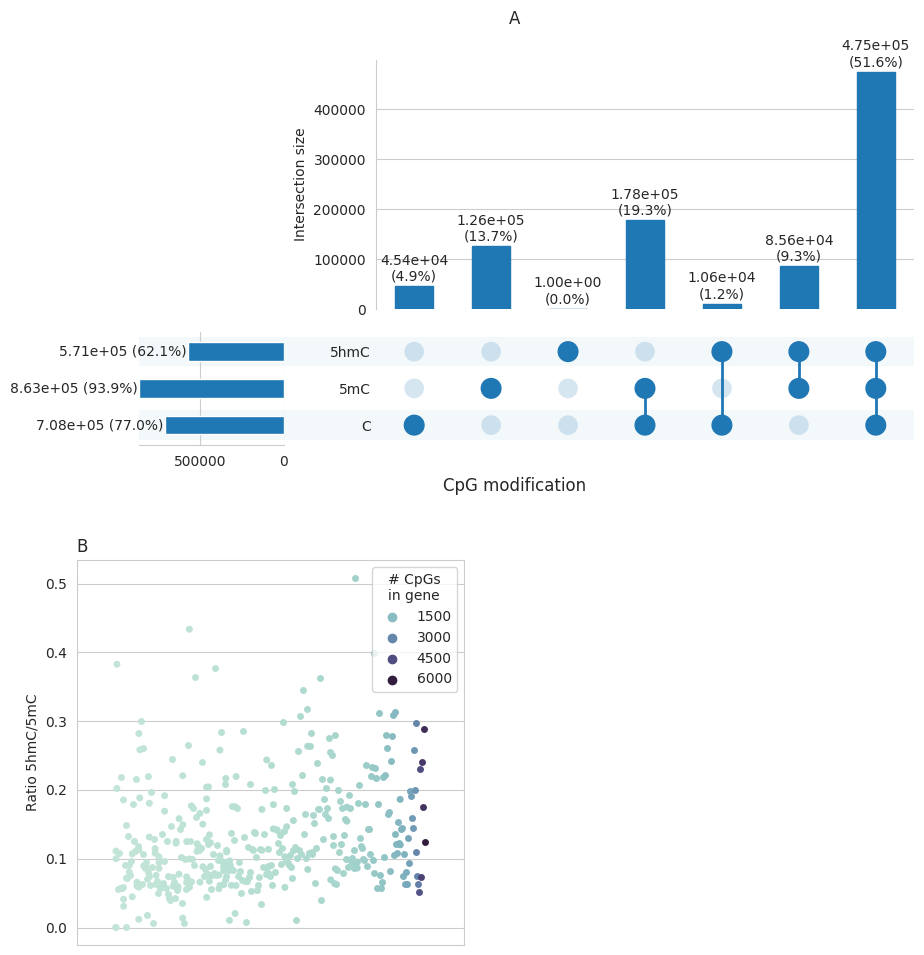

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, fig)

fig1 = fig.add_subfigure(gs[0, :])
upset.plot(fig1)
fig1.suptitle("A")
fig1.supxlabel("CpG modification")

fig2 = fig.add_subfigure(gs[1, 0])
ax2 = fig2.add_subplot()

sns.stripplot(genes_df, y="ratio", hue="CpG_count", dodge=True, legend="brief", ax=ax2, palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
ax2.set_title("B", loc="left")
ax2.set_ylabel("Ratio 5hmC/5mC")
sns.move_legend(ax2, "upper right", title="# CpGs\nin gene")

fig.show()